# Replication of results from Anderson et al. 2016

## Initializing

Notes :
- sampling frequency
- initial parameters (grid search, iterative)


In [1]:
import numpy as np
import scipy.io
import xarray as xr
import pyhsmm_mvpa as hsmm
from itertools import repeat
import multiprocessing 

cpus = multiprocessing.cpu_count()

%load_ext autoreload
%autoreload 2


# Initial fit

Reading the data

In [2]:
mat = scipy.io.loadmat('matlab/newbumps/starter.mat')

data = np.array(mat['normedscore10'])
starts = np.array(mat['x'][:,0]) -1#correcting to be 0 indexed
ends = np.array(mat['y'][:,0])-1#correcting to be 0 indexed
subjects = np.array(mat['subjects'])-1 #correcting to be 0 indexed

Initializing the hsmm object with data, starts, sampling frequency... all things shared across the different following fit

In [3]:
init = hsmm.hsmm(data, starts, ends, sf=100, bump_width=50)

testing single fit for a 2 bump model

In [4]:
two_bumps = init.fit_single(2)

Estimating parameters for 2 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:161: UserWarning: Using default parameters value for magnitudes and gamma
  warnings.warn('Using default parameters value for magnitudes and gamma')


Parameters estimated for 2 bumps model


Example output:

In [5]:
two_bumps

<xarray.Dataset>
Dimensions:      (stage: 3, params: 2, component: 10, bump: 2, samples: 300,
                  trial: 18271)
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  float64 -6.74e+04
    parameters   (stage, params) float64 2.0 10.42 2.0 23.67 2.0 18.29
    magnitudes   (component, bump) float64 0.8692 -1.087 ... 0.05069 -0.07692
    eventprobs   (samples, trial, bump) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

## Iterative estimation of bumps from 1 to max_bumps

That is the multi CPU version, less handy for results exploitation for now but the fastest:

In [ ]:
import multiprocessing 

cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=cpus) as pool:
    iterative_results = pool.map(init.fit_single, np.arange(1,init.max_bumps()+1))

#For the single CPU automated version : init.fit_iterative(init.max_bumps())

Estimating parameters for 1 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:165: UserWarning: Using default parameters value for magnitudes and gamma
  warnings.warn('Using default parameters value for magnitudes and gamma')


Estimating parameters for 2 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:165: UserWarning: Using default parameters value for magnitudes and gamma
  warnings.warn('Using default parameters value for magnitudes and gamma')


Estimating parameters for 3 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:165: UserWarning: Using default parameters value for magnitudes and gamma
  warnings.warn('Using default parameters value for magnitudes and gamma')


Estimating parameters for 4 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:165: UserWarning: Using default parameters value for magnitudes and gamma
  warnings.warn('Using default parameters value for magnitudes and gamma')


Estimating parameters for 5 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:165: UserWarning: Using default parameters value for magnitudes and gamma
  warnings.warn('Using default parameters value for magnitudes and gamma')


Estimating parameters for 6 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:165: UserWarning: Using default parameters value for magnitudes and gamma
  warnings.warn('Using default parameters value for magnitudes and gamma')


Estimating parameters for 7 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:165: UserWarning: Using default parameters value for magnitudes and gamma
  warnings.warn('Using default parameters value for magnitudes and gamma')


Estimating parameters for 8 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:165: UserWarning: Using default parameters value for magnitudes and gamma
  warnings.warn('Using default parameters value for magnitudes and gamma')


Parameters estimated for 1 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 4 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 5 bumps model
Parameters estimated for 7 bumps model
Parameters estimated for 8 bumps model
Parameters estimated for 6 bumps model


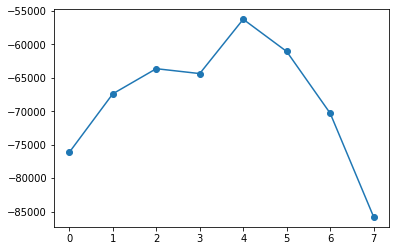

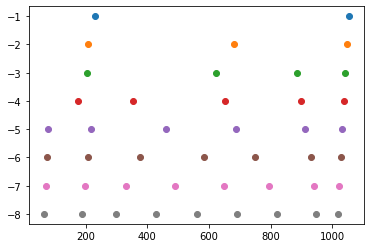

In [54]:
import matplotlib.pyplot as plt

plt.plot([x.likelihoods.values for x in iterative_results],'o-')
plt.show()
for nbump_model in iterative_results:
    nbump= len(nbump_model.bump)
    plt.plot(np.cumsum(init.bump_times(nbump_model,nbump)), -np.repeat(nbump, len(init.bump_times(nbump_model,nbump))),'o')

## Roll-back estimation of bumps from max_bumps to 1 bumps
At each iteration we leave one bump out from the previous best fit solution.

Getting the max n_bumps estimate first

In [47]:
max_estimates = iterative_results[-1]

In [48]:
max_estimates

<xarray.Dataset>
Dimensions:      (stage: 9, params: 2, component: 10, bump: 8, samples: 300,
                  trial: 18271)
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  float64 -8.58e+04
    parameters   (stage, params) float64 2.0 3.248 2.0 6.154 ... 6.362 2.0 3.526
    magnitudes   (component, bump) float64 -0.2288 0.8462 ... -0.1321 -0.1305
    eventprobs   (samples, trial, bump) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [79]:
bump_loo_results = []
for n_bumps in np.arange(len(max_estimates.bump),1,-1):
    print(n_bumps)
    n_bumps_list = np.arange(n_bumps)
    lists_bumps = [n_bumps_list[np.where(n_bumps_list != x)] for x in n_bumps_list]
    n_flats_list = np.arange(1,n_bumps+1)
    lists_flats = [n_flats_list[np.where(n_flats_list != x)] for x in n_flats_list]
    lists_flats = [np.insert(x,0,0) for x in lists_flats]#The stage removal isn't good
    with multiprocessing.Pool(processes=cpus) as pool:
        bump_loo_likelihood_temp = pool.starmap(init.calc_EEG_50h, 
            zip(max_estimates.magnitudes.values.T[lists_bumps,:], 
                max_estimates.parameters.values[lists_flats,:],
                #repeat(np.tile([1,50], (n_bumps,1))),
                repeat(n_bumps-1),repeat(True)))
    lkhs = [x[0] for x in bump_loo_likelihood_temp]
    best = np.where(lkhs==np.max(lkhs))
    bump_loo_results.append(bump_loo_likelihood_temp[best[0][0]])


8
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model
Estimating parameters for 7 bumps model


ValueError: operands could not be broadcast together with shapes (1950396,7) (1950396,10) 

In [78]:
bump_loo_results[0][2]

IndexError: list index out of range

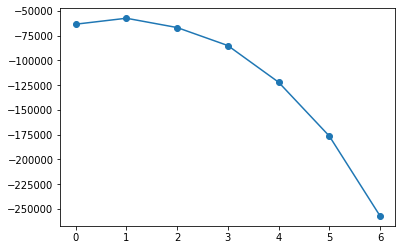

AttributeError: 'list' object has no attribute 'bump'

In [80]:
import matplotlib.pyplot as plt

plt.plot([x[0] for x in bump_loo_results],'o-')
plt.show()
for nbump_model in bump_loo_results:
    nbump= len(nbump_model.bump)
    plt.plot(np.cumsum(init.bump_times(nbump_model,nbump)), -np.repeat(nbump, len(init.bump_times(nbump_model,nbump))),'o')

In [69]:
best[0][0]

4

In [63]:
np.where(lkhs==np.max(lkhs))

(array([3]),)

In [62]:
lkhs

[-151739.5125755245,
 -153770.9756856228,
 -143647.34377310812,
 -140572.3950861002,
 -141085.10376960217,
 -141748.32707357313,
 -146177.62239907615]

In [ ]:
[print(x) for x in zip(max_estimates.magnitudes.values.T[lists_bumps,:], 
                 max_estimates.parameters.values[lists_flats,:],
                      repeat(n_bumps-1),repeat(True))]

(array([[ 0.84621455, -1.09350653,  0.03119055, -0.31537429, -0.85111607,
         0.39107634, -0.64922699, -0.28001949, -0.16480132,  0.07871282],
       [ 0.41892338, -0.49376603, -0.1177151 ,  0.41331076, -0.25246357,
         0.42756363, -0.3064665 , -0.29134338, -0.11000977, -0.16401902],
       [-0.3009668 ,  0.2812246 , -0.10717156,  0.11362655,  0.06201985,
         0.1690863 , -0.14451293,  0.03261157, -0.00793362, -0.31246449],
       [-0.51337889,  0.40762093, -0.05309462, -0.29977205,  0.03292016,
         0.01637182, -0.03254269,  0.22091656,  0.00224371, -0.10211127],
       [-0.74967474,  0.24485125, -0.00897984, -0.27622957, -0.07839714,
        -0.03143957, -0.04678163,  0.30686169,  0.0483025 ,  0.00687105],
       [ 0.20927796,  0.20120753, -0.01254018, -0.30063644,  0.29232739,
        -0.25344884,  0.42188862,  0.19533132,  0.29852942, -0.13207596]]), array([[2.        , 3.24782885],
       [2.        , 5.47751831],
       [2.        , 6.54010595],
       [2.      

[None, None, None, None, None, None, None]

In [ ]:
bump_loo_likelihood

In [43]:
from itertools import repeat
[print(x) for x in zip(initial_estimates.magnitudes.values.T[lists_bumps,:], 
                initial_estimates.parameters.values[lists_flats,:],
                      repeat(n_bumps-1))]

NameError: name 'initial_estimates' is not defined

In [99]:
initial_estimates.magnitudes.values[:,left_out_bump]

array([[-0.2287517 ,  0.41892338, -0.3009668 , -0.51337889, -0.74967474,
         0.20927796,  0.36454543],
       [-0.02618698, -0.49376603,  0.2812246 ,  0.40762093,  0.24485125,
         0.20120753,  0.48123711],
       [ 0.06418849, -0.1177151 , -0.10717156, -0.05309462, -0.00897984,
        -0.01254018,  0.08376048],
       [ 0.01685507,  0.41331076,  0.11362655, -0.29977205, -0.27622957,
        -0.30063644,  0.40841219],
       [ 0.62286154, -0.25246357,  0.06201985,  0.03292016, -0.07839714,
         0.29232739,  0.06085019],
       [-0.0404875 ,  0.42756363,  0.1690863 ,  0.01637182, -0.03143957,
        -0.25344884, -0.31207435],
       [ 0.50168636, -0.3064665 , -0.14451293, -0.03254269, -0.04678163,
         0.42188862,  0.02367395],
       [-0.41318311, -0.29134338,  0.03261157,  0.22091656,  0.30686169,
         0.19533132,  0.25358635],
       [-0.2760921 , -0.11000977, -0.00793362,  0.00224371,  0.0483025 ,
         0.29852942,  0.30849289],
       [ 0.57937374, -0.1640

In [89]:
bump_loo_likelihood

[-92747.44303352272]

In [5]:
no.arange(9,1)

NameError: name 'no' is not defined

In [ ]:
import multiprocessing 

cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=cpus) as pool:
    results = pool.map(init.fit_single, np.arange(1,2))

In [138]:
initial_estimates = init.fit_single(1)

Estimating parameters for 1 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:161: UserWarning: Using default parameters value for magnitudes and gamma
  warnings.warn('Using default parameters value for magnitudes and gamma')


Parameters estimated for 1 bumps model


In [68]:
iterative_estimates = init.fit_iterative(2)
print(iterative_estimates)
init.fit_iterative(2,parameters=iterative_estimates.parameters.values, magnitudes=iterative_estimates.magnitudes.values)

/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:161: UserWarning: Using default parameters value for magnitudes and gamma
  warnings.warn('Using default parameters value for magnitudes and gamma')


<xarray.Dataset>
Dimensions:     (n_bumps: 2, stage: 3, params: 2, component: 10, bump: 2)
Dimensions without coordinates: n_bumps, stage, params, component, bump
Data variables:
    likelihood  (n_bumps) float64 -7.615e+04 -6.74e+04
    parameters  (n_bumps, stage, params) float64 2.0 11.49 2.0 ... 2.0 18.29
    magnitudes  (n_bumps, component, bump) float64 0.8388 nan ... -0.07692


<xarray.Dataset>
Dimensions:     (n_bumps: 2, stage: 3, params: 2, component: 10, bump: 2)
Dimensions without coordinates: n_bumps, stage, params, component, bump
Data variables:
    likelihood  (n_bumps) float64 -7.615e+04 -6.74e+04
    parameters  (n_bumps, stage, params) float64 2.0 11.49 2.0 ... 2.0 18.29
    magnitudes  (n_bumps, component, bump) float64 0.8388 nan ... -0.07692

In [65]:
initial_estimates

<xarray.Dataset>
Dimensions:      (stage: 2, params: 2, component: 10, bump: 1, samples: 300,
                  trial: 18271)
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  float64 -7.615e+04
    parameters   (stage, params) float64 2.0 11.49 2.0 41.13
    magnitudes   (component, bump) float64 0.8388 -1.232 ... -0.1847 0.01124
    eventprobs   (samples, trial, bump) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [47]:
a=np.arange(1,28).reshape(3,3,3)

In [51]:
a.sum(axis=2)

array([[ 6, 15, 24],
       [33, 42, 51],
       [60, 69, 78]])

In [29]:
initial_estimates.bump

<xarray.DataArray 'bump' (bump: 7)>
array([0, 1, 2, 3, 4, 5, 6])
Dimensions without coordinates: bump

In [28]:
np.arange(np.max(initial_estimates.bump))

array([0, 1, 2, 3, 4, 5])

In [35]:
initial_estimates.magnitudes

<xarray.DataArray 'magnitudes' (component: 10, bump: 7)>
array([[-0.23720847,  0.8586386 ,  0.45124144, -0.32373778, -0.36754849,
        -0.28108556,  0.4004604 ],
       [ 0.1542926 , -1.11735336, -0.53047815,  0.22728637,  0.41498589,
         0.54907881,  0.4954078 ],
       [ 0.04559097,  0.02848087, -0.09265243, -0.12978779, -0.10614803,
        -0.09139781,  0.06974755],
       [ 0.08695621, -0.32578377,  0.48253903,  0.16689694, -0.27631524,
        -0.25358869,  0.33800248],
       [ 0.79578218, -0.87980019, -0.23811934,  0.11163558,  0.15644206,
        -0.13242173,  0.11258207],
       [-0.01135325,  0.40857113,  0.38330615,  0.18922912,  0.06114501,
         0.03692674, -0.32064054],
       [ 0.55771605, -0.69303947, -0.24877737, -0.12240566,  0.00824393,
        -0.14616817,  0.08345912],
       [-0.4512181 , -0.29017993, -0.29749777, -0.0091588 ,  0.19441473,
         0.33282112,  0.25973066],
       [-0.25646116, -0.16437636, -0.10860895,  0.02900031,  0.02718487,
         0.07898751,  0.34708263],
       [ 0.60546279,  0.06756241, -0.11922721, -0.41542628, -0.24751506,
        -0.03452771, -0.15226695]])
Dimensions without coordinates: component, bump

In [73]:
initial_estimates.parameters.sel(stage=[0,1])

<xarray.DataArray 'parameters' (stage: 2, params: 2)>
array([[2.        , 4.19538221],
       [2.        , 2.66145563]])
Dimensions without coordinates: stage, params

## Iterative fit

Parallel iterative fit

In [49]:
init = hsmm.hsmm(data, starts, ends, sf=100,bump_width = 50)

2
5


In [50]:
import multiprocessing 

cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=cpus) as pool:
    results = pool.map(init.fit_single, np.arange(1,2))
    

Estimating parameters for 1 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:162: UserWarning: Using default parameters value for magnitudes and gamma
  magnitudes = np.zeros((self.n_dims,n_bumps))


Parameters estimated for 1 bumps model


In [51]:
results

[<xarray.Dataset>
 Dimensions:      (stage: 2, params: 2, component: 10, bump: 1, samples: 300,
                   trial: 18271)
 Dimensions without coordinates: stage, params, component, bump, samples, trial
 Data variables:
     likelihoods  float64 -8.765e+04
     parameters   (stage, params) float64 2.0 32.89 2.0 18.23
     magnitudes   (component, bump) float64 -1.237 0.347 ... 0.1337 -0.05722
     eventprobs   (samples, trial, bump) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0]

results

Comparing with other bump width :

In [6]:
results_initial_bump_width = results

In [46]:
init = hsmm.hsmm(data, starts, ends, sf=100,bump_width = 40)

2
4


In [47]:
import multiprocessing 

cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=cpus) as pool:
    results_70 = pool.map(init.fit_single, np.arange(1,3))
    

Estimating parameters for 1 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:162: UserWarning: Using default parameters value for magnitudes and gamma
  magnitudes = np.zeros((self.n_dims,n_bumps))


Estimating parameters for 2 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:162: UserWarning: Using default parameters value for magnitudes and gamma
  magnitudes = np.zeros((self.n_dims,n_bumps))


Parameters estimated for 1 bumps model
Parameters estimated for 2 bumps model


In [48]:
results_70

[<xarray.Dataset>
 Dimensions:      (stage: 2, params: 2, component: 10, bump: 1, samples: 300,
                   trial: 18271)
 Dimensions without coordinates: stage, params, component, bump, samples, trial
 Data variables:
     likelihoods  float64 -7.12e+04
     parameters   (stage, params) float64 2.0 11.4 2.0 39.72
     magnitudes   (component, bump) float64 0.8804 -1.327 ... -0.199 0.0009981
     eventprobs   (samples, trial, bump) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0,
 <xarray.Dataset>
 Dimensions:      (stage: 3, params: 2, component: 10, bump: 2, samples: 300,
                   trial: 18271)
 Dimensions without coordinates: stage, params, component, bump, samples, trial
 Data variables:
     likelihoods  float64 -6.018e+04
     parameters   (stage, params) float64 2.0 10.51 2.0 21.87 2.0 16.99
     magnitudes   (component, bump) float64 0.9199 -1.235 ... 0.03953 -0.06129
     eventprobs   (samples, trial, bump) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0]

Parallel iterative fit

### Downsampling test 

In [34]:
np.shape(data)

(1950396, 10)

In [39]:
down_sampled_data = data[0::2,:]

In [42]:
np.shape(down_sampled_data)

(975198, 10)

In [40]:
init_ds = hsmm.hsmm(down_sampled_data, starts, ends, sf=50 ,bump_width = 50)

[10. 30.]


In [ ]:
FIX START AND ENDS !!

In [41]:
import multiprocessing 

cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=cpus) as pool:
    results_70 = pool.map(init_ds.fit_single, np.arange(1,8))
    

Estimating parameters for 1 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 4 bumps model
Estimating parameters for 5 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 7 bumps model


ValueError: could not broadcast input array from shape (17,1) into shape (59,1)